In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from math import sqrt, exp, log
from scipy.stats import norm
import dataFactory
import riskModelling
import strGenerator
import yfinance as yf
import demo
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

# Prefix
## Project
This model supports the calculation of VaR (value at risk) and ES (expected shortfall) of any given number of stocks (identified with their tickers) and the portfolio as a whole, based on 3 main methods: 
- **Parametric Method:** VaR and ES are directly calculated with closed form equations. 
- **Monte Carlo simulations:** VaR and ES are calculated based on simulated projected results. 
## Features
### Arbitrary Stock Ticker Input
### Graphical Comparison
### Customization

## Installation
To run this project, you need to install the following packages: 
- pandas: https://pandas.pydata.org
- numpy: https://numpy.org
- scipy: https://scipy.org
- yfinance: https://pypi.org/project/yfinance/

## Contribution
This project and the corresponding model is accomplished by Yanjie Liu, Qingyi Yan and Ming Yin, students of Math GR5320, Fall 2021 at Columbia University. 

# Data Collection

In [2]:
tickerList = dataFactory.readTickerList()
df = dataFactory.dwnloadAndJoin(tickerList)
numList = dataFactory.readNumList(tickerList)
dataFactory.positionCalc(df, tickerList, numList)
df = df.iloc[-25 * 252:]
print('Data of ', tickerList, " and the portfolio was collected. To speed up the model, only the latest 25 years of data is preserved. ")

JNJ
[*********************100%***********************]  1 of 1 completed
PFE
[*********************100%***********************]  1 of 1 completed
Data of  ['JNJ', 'PFE']  and the portfolio was collected. To speed up the model, only the latest 25 years of data is preserved. 


# Parameter Calculation

In [3]:
# calculate daily value of portfolio
dataFactory.portfolioCalc(df, tickerList, numList)

# calculate log return of each stock and portfolio
tickerList.append('portfolio')
for i in range(len(tickerList)): 
    dataFactory.logRtnCalc(df, tickerList[i], 1)

In this model, we only support historical window length of 2, 5 or 10 years. 

In [5]:
windowList = [2, 5, 10]
lambdaList = [0.9972531953, 0.9989003714, 0.9994500345]
for i in range(len(tickerList)): 
    for j in range(len(windowList)): 
        dataFactory.gbmParamCalc(df, ticker = tickerList[i], window = windowList[j], method = 'window')
        dataFactory.gbmParamCalc(df, tickerList[i], windowList[j], 'exp', lambdaList[j])

# Risk Parameter Calculation with Parametric Method
In this model, we only give VaR and ES with percentile [99%, 97.5%, 95%] and time step [5, 10, 30] days. And we assume that we would invest $100,000 on each date. 

In [6]:
pList = [0.99, 0.975, 0.95]
tList = [5 / 252, 10 / 252, 30 / 252]
positionList = ['long', 'short']
riskList = ['VaR', 'ES']
v0 = 100000

for i in range(len(tickerList)):
    print("Started to calculate risk parameters for ", tickerList[i], ", using parametric methods.")
    for j in range(len(windowList)):
        for m in range(len(pList)):
            for n in range(len(tList)):
                for x in range(len(positionList)):
                    for y in range(len(riskList)):
                        dataFactory.PARAMriskCalc(df, v0 = 100000, ticker = tickerList[i], p = pList[m], t = tList[n], estWindow = windowList[j], riskType = riskList[y], estMethod = 'window', position = positionList[x])
                        dataFactory.PARAMriskCalc(df, v0 = 100000, ticker = tickerList[i], p = pList[m], t = tList[n], estWindow = windowList[j], riskType = riskList[y], estMethod = 'exp', position = positionList[x])
    print(tickerList[i], " 's risk parameters are successfully calculated, using parametric method. \n")

Started to calculate risk parameters for  JNJ , using parametric methods.
JNJ  's risk parameters are successfully calculated, using parametric method. 

Started to calculate risk parameters for  PFE , using parametric methods.
PFE  's risk parameters are successfully calculated, using parametric method. 

Started to calculate risk parameters for  portfolio , using parametric methods.
portfolio  's risk parameters are successfully calculated, using parametric method. 



=======================RUN TILL HERE=============================

# Risk Parameter Calculation with Monte Carlo Simulations
We don't recommend running Monte Carlo simulations for all provided parameters (different p, t, positions, etc., ) as this could possibly take hours or even days. If you want to run Monte Carlo simulation on any specified parameters, simply run the code as below: 

In [7]:
# UNCOMMENT THE NEXT LINE AND CHANGE THE PARAMETERS AS YOU LIKE
# dataFactory.MCriskCalc(df, v0, ticker, p, t, estWindow, riskType, estMethod, position)

For example, if we would like to compare the results of 99% 5-day VaR of JNJ, estimated with 2-year equivalent lambda, from simulations and parametric equations: 

In [8]:
dataFactory.MCriskCalc(df, v0 = 100000, ticker = 'JNJ', p = 0.99, t = 5 / 252, riskType = 'VaR', estWindow = 5, estMethod = 'window', position = 'long')
dataFactory.MCriskCalc(df, v0 = 100000, ticker = 'JNJ', p = 0.99, t = 5 / 252, riskType = 'ES', estWindow = 5, estMethod = 'window', position = 'long')

# Plot
Even though all the possible combinations of parameters were taken into account and the corresponding VaR and ES are directly stored in the dataframe, we suggest users to call the plot as you are interested. 
## Parametric
### Fixed Estimation Window and Position, Different Estimation Methods

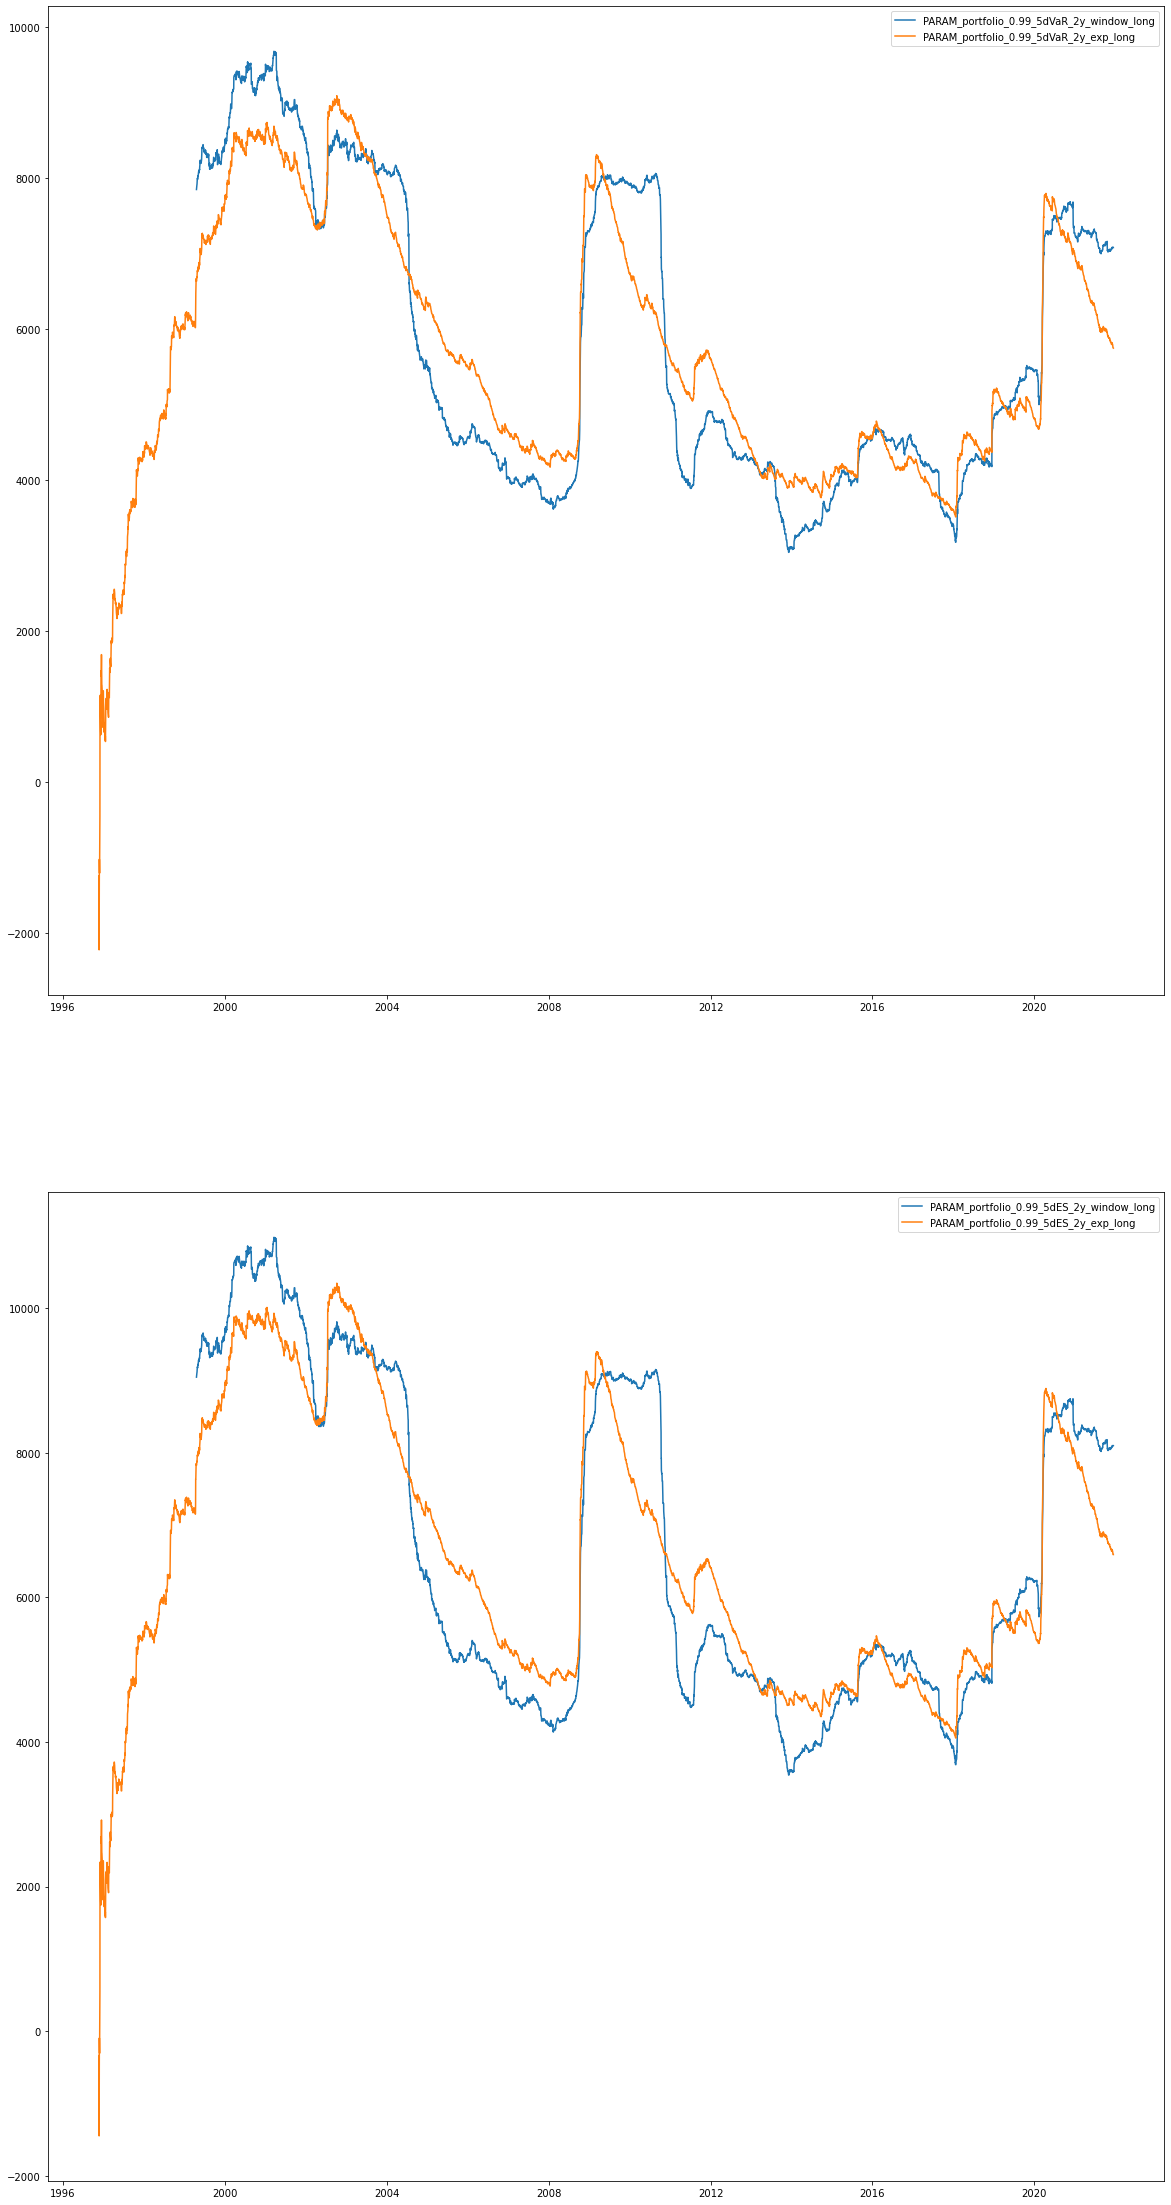

In [9]:
demo.fWinDiffMethodPlot(df, 'PARAM', 'portfolio', 0.99, 5, 2)

### Fixed Estimation Method and Position, Different Estimation Window

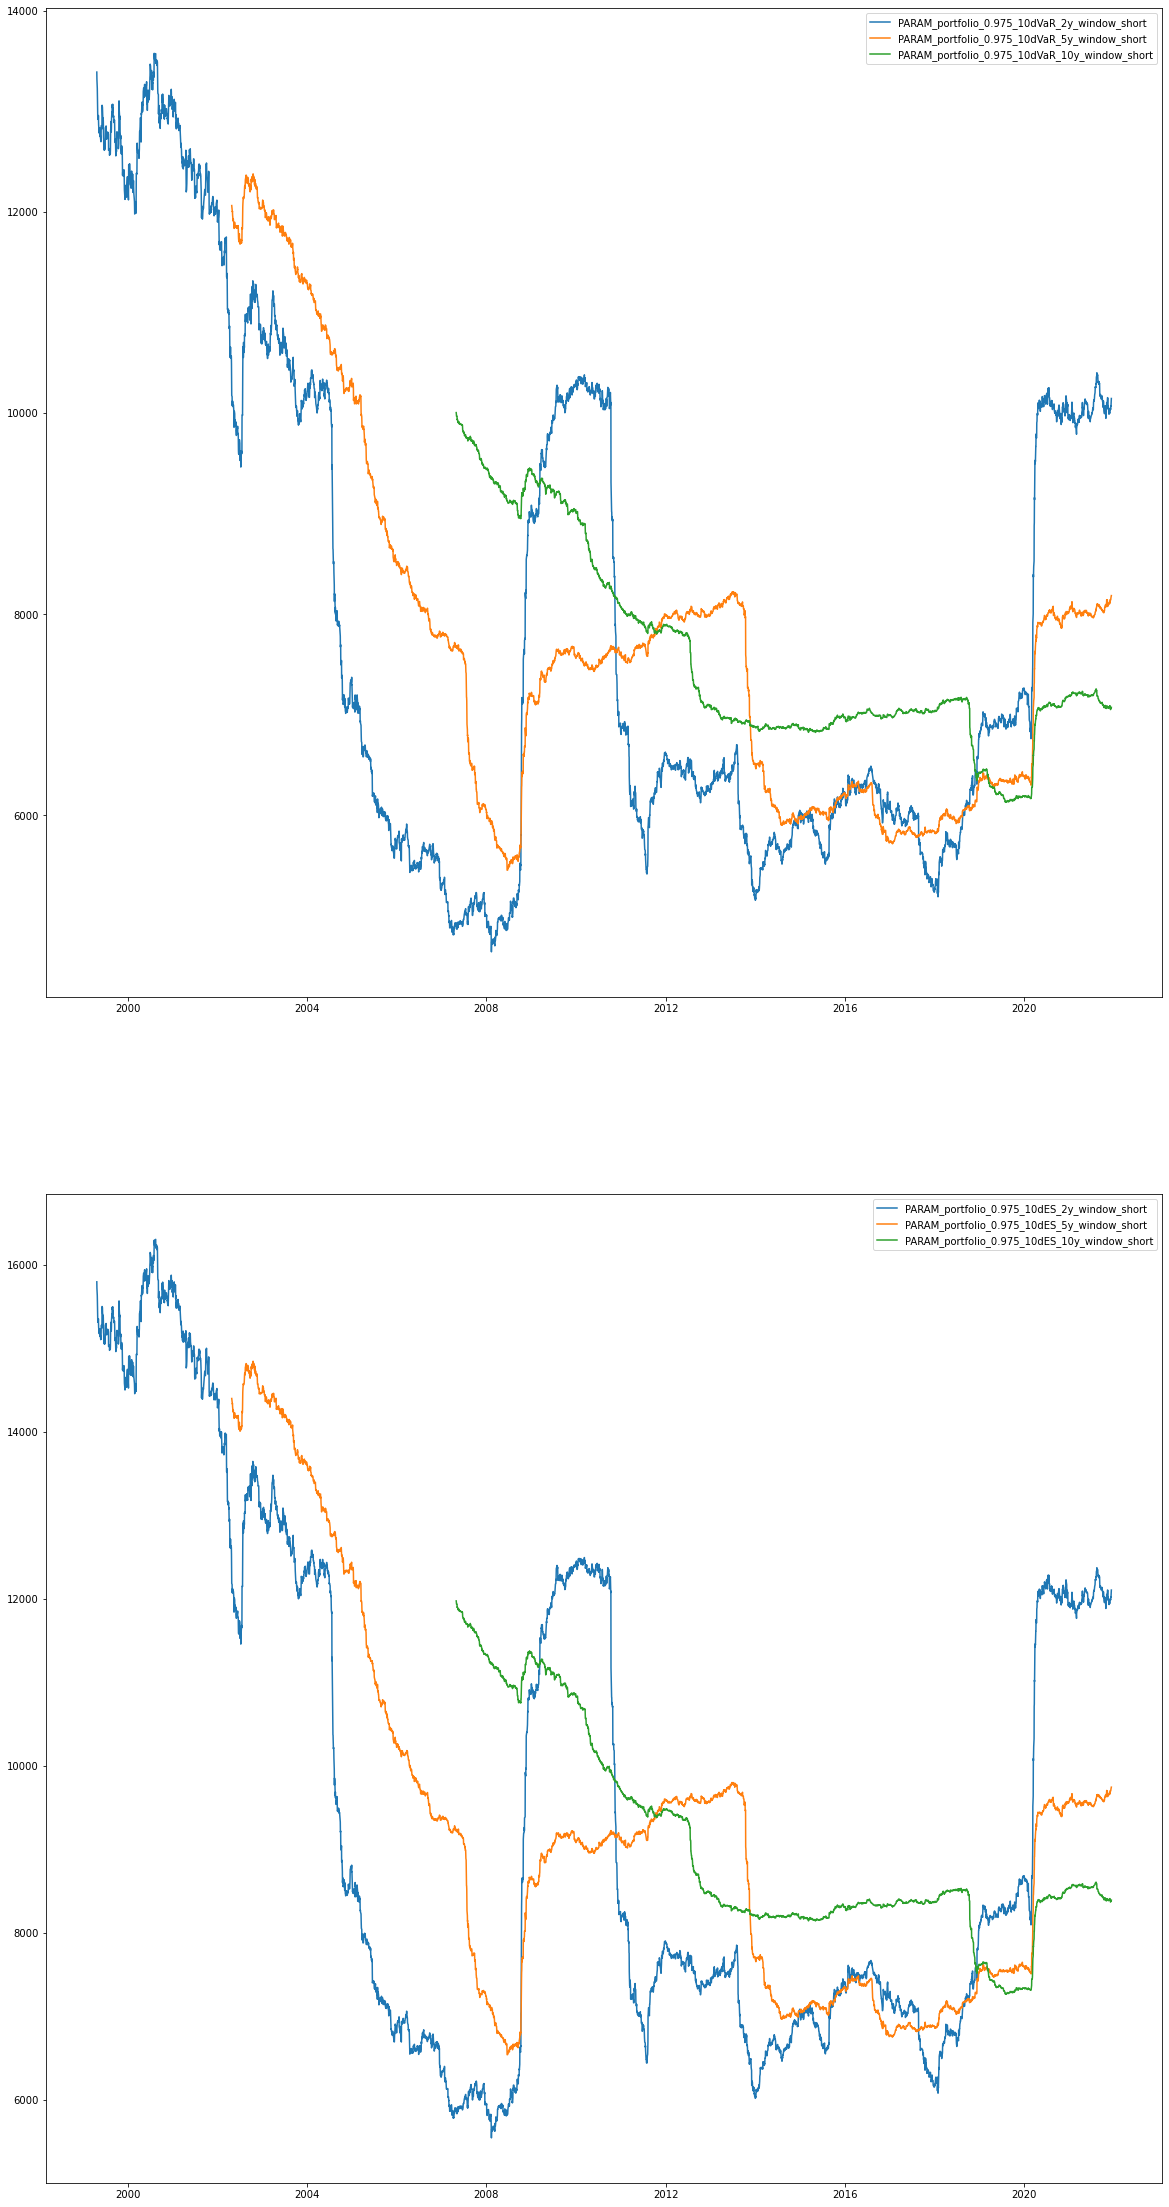

In [10]:
demo.fMethodDiffWinPlot(df, 'PARAM', 'portfolio', 0.975, 10, [2, 5, 10], 'window', 'short')

### Fixed Estimation Method and Window, Different Positions

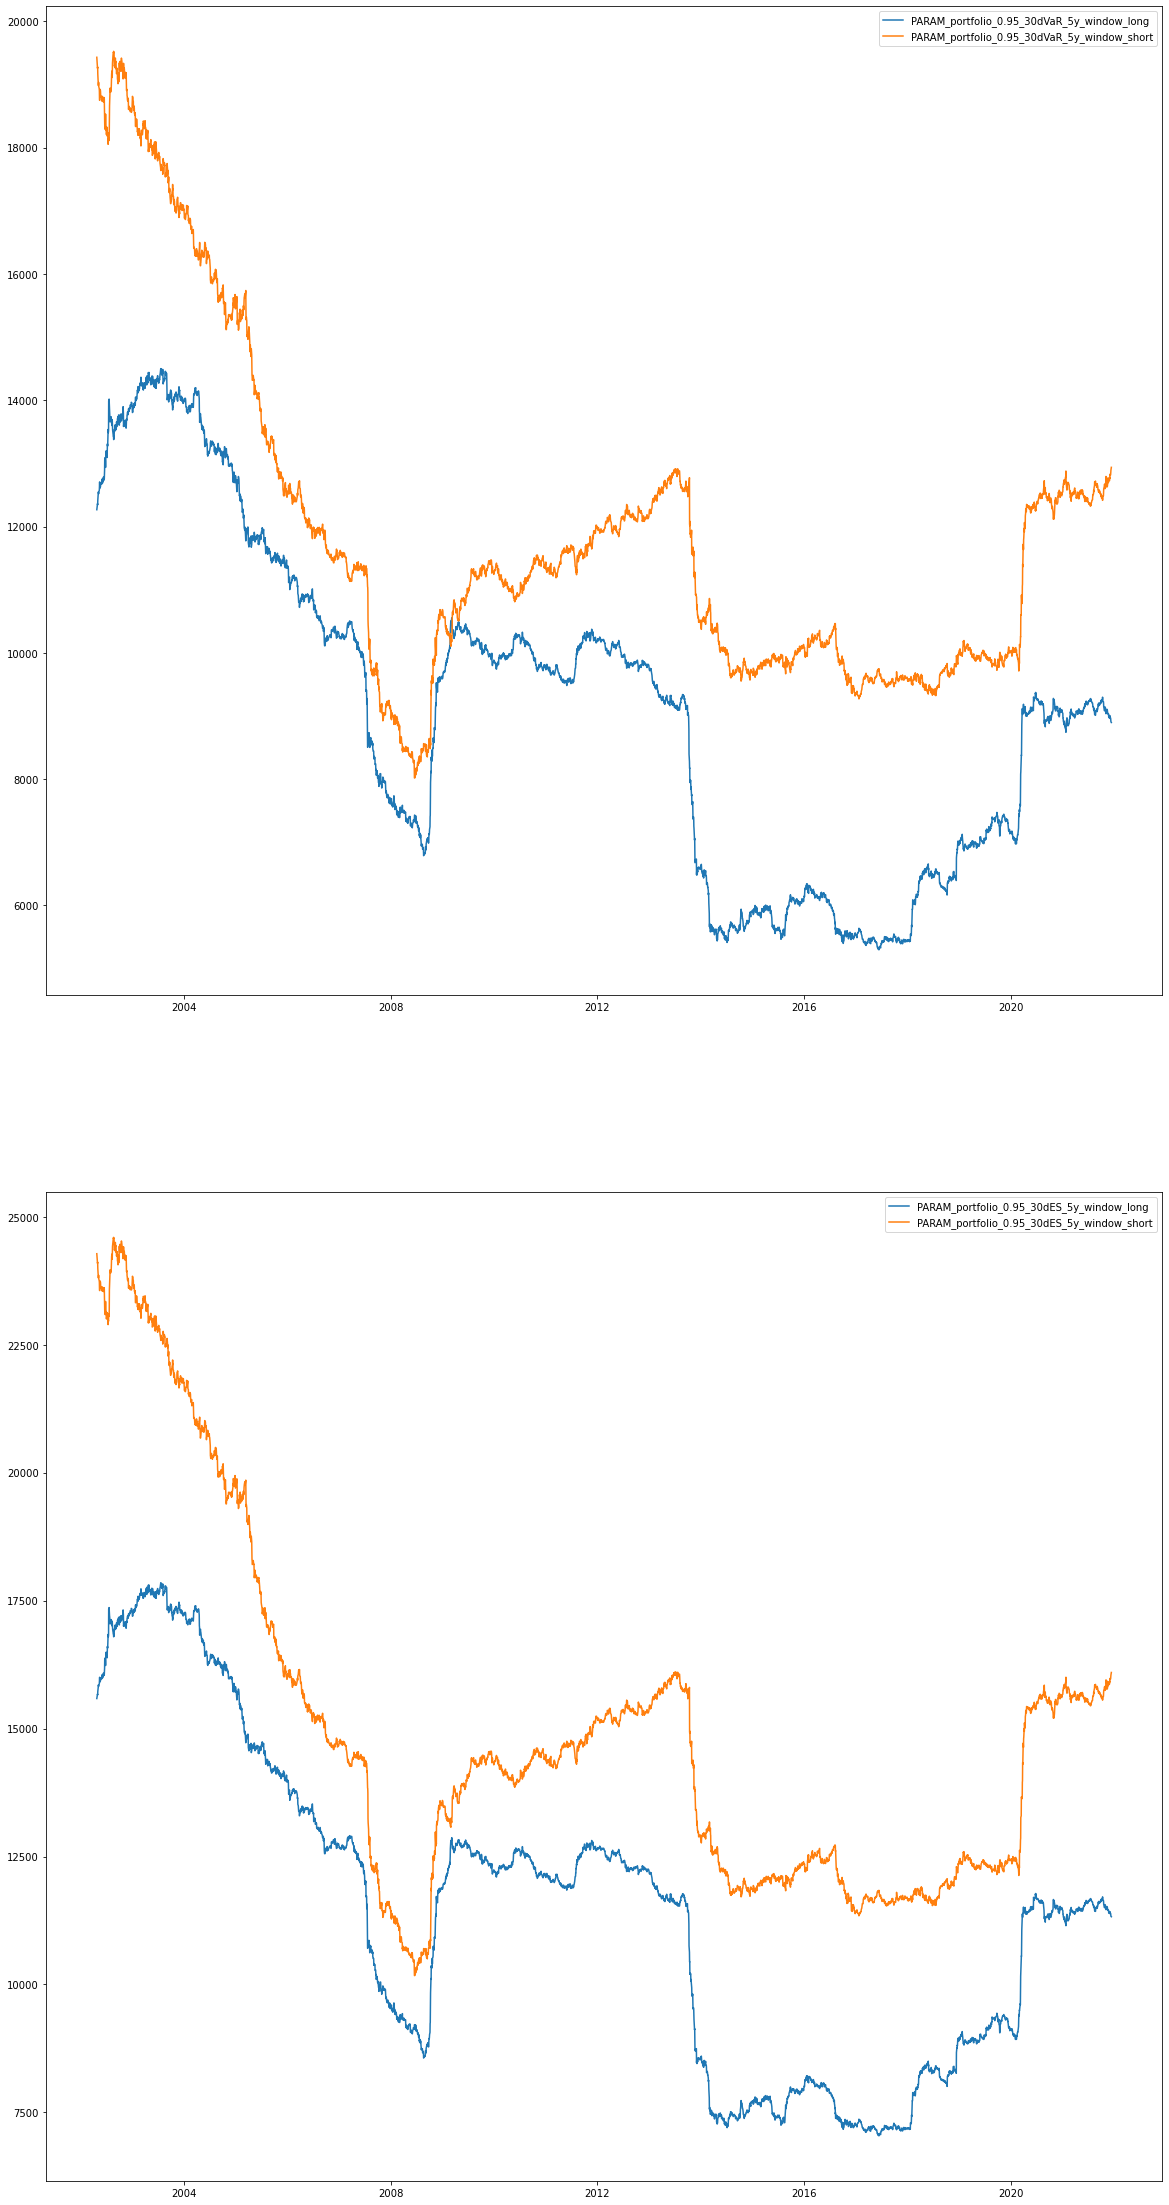

In [11]:
demo.fWinFMethodDiffPosition(df, 'PARAM', 'portfolio', 0.95, 30, 5, 'window')

## Monte Carlo

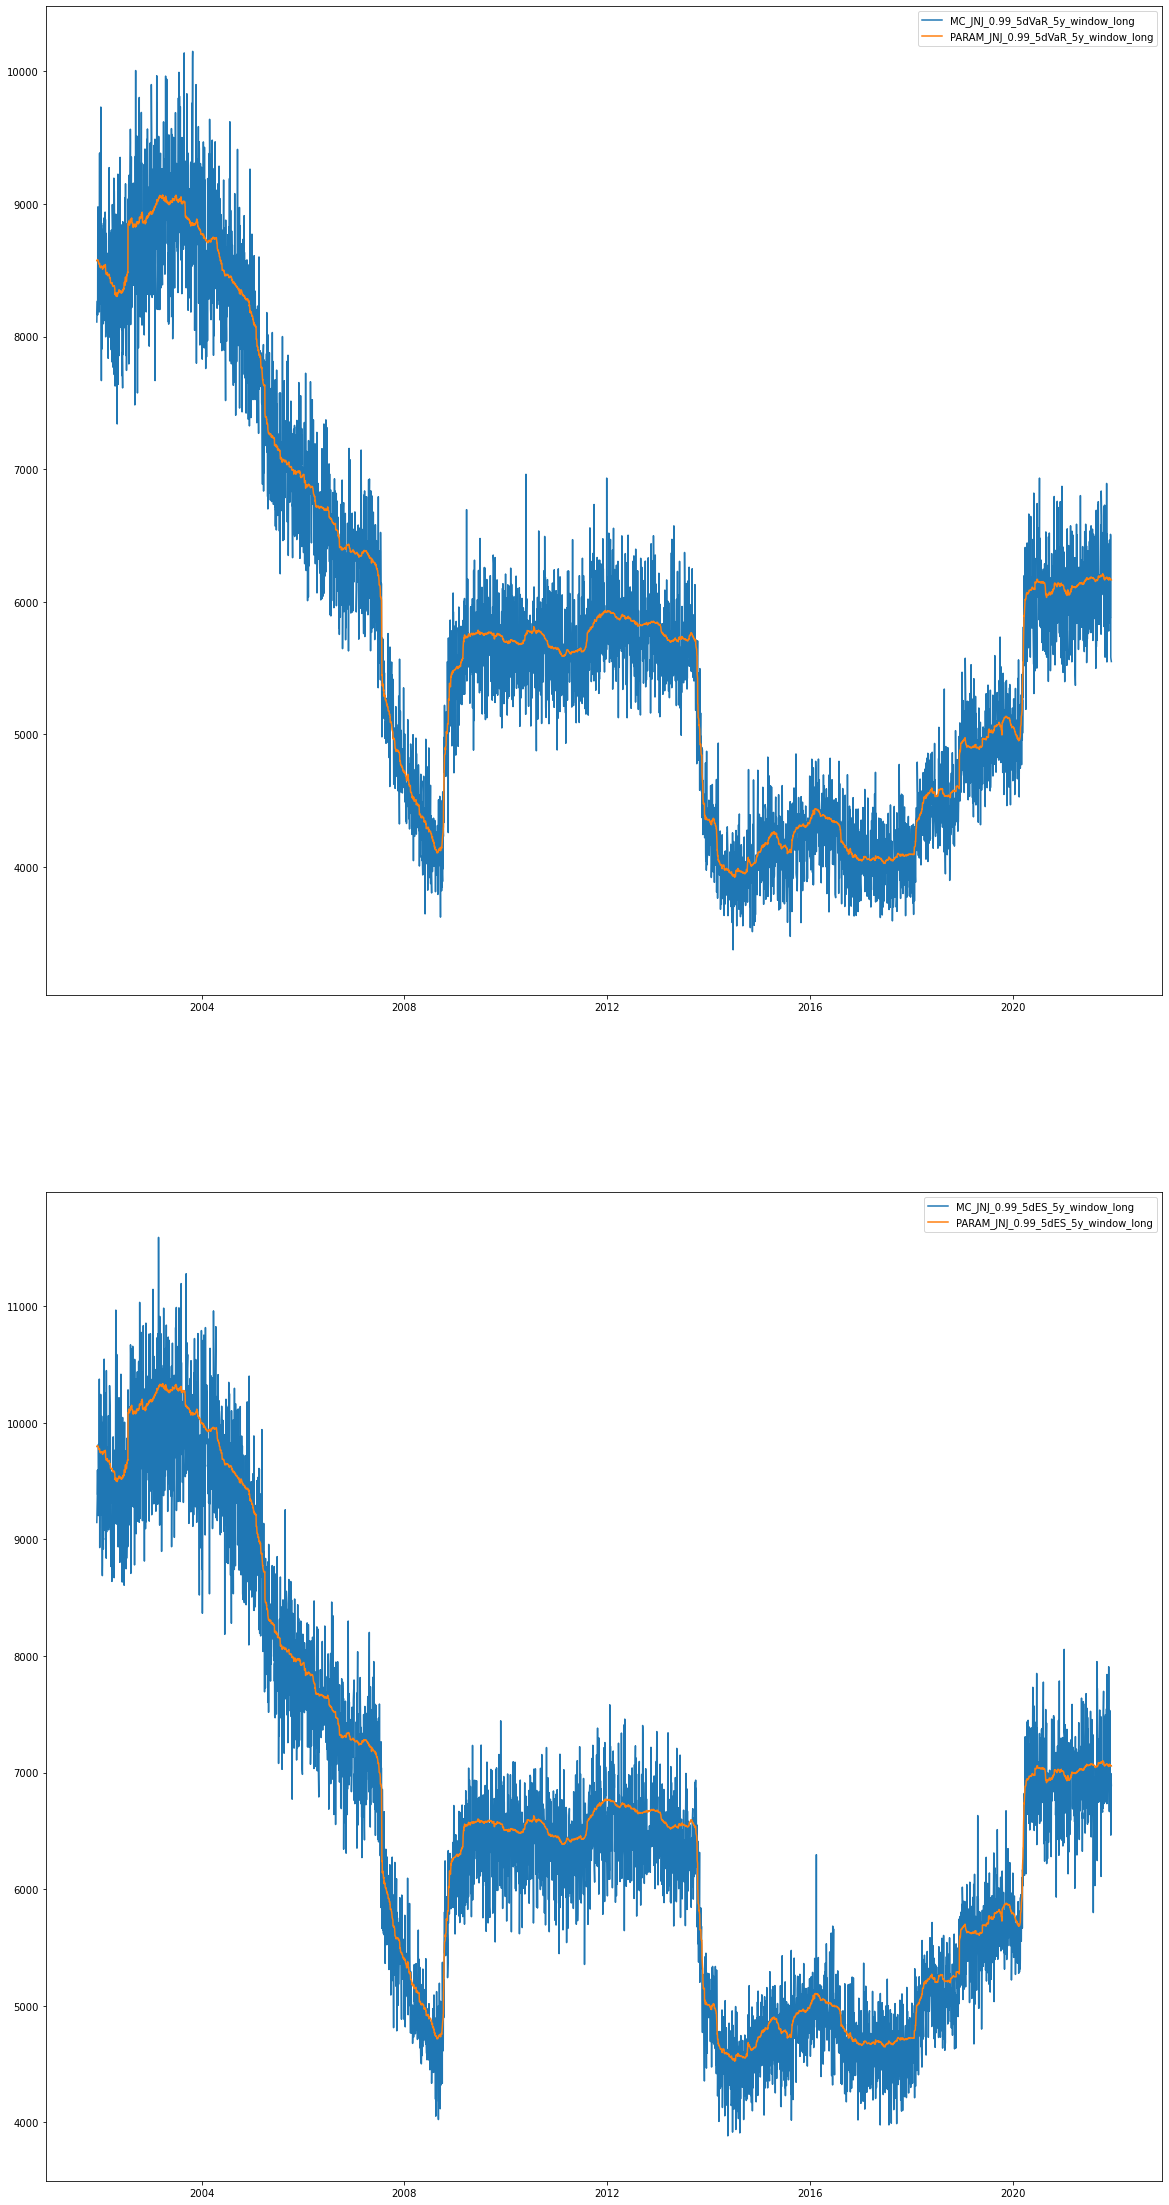

In [12]:
demo.paramMC(df, 'JNJ', 0.99, 5, 5, 'window', 'long')

## Historical

In [13]:
# Calculate log return as needed. (5-day, 10-day, 30-day log rtn)
for i in range(len(tickerList)): 
    for j in range(len(tList)): 
        dataFactory.logRtnCalc(df, tickerList[i], int(tList[j] * 252))

In [14]:
# for i in range(len(tickerList[i])): 
#     for j in range(len(tList)): 
#         dataFactory.

dataFactory.HISTriskCalc(df, 100000, 'JNJ', 0.99, 5 / 252, 5)

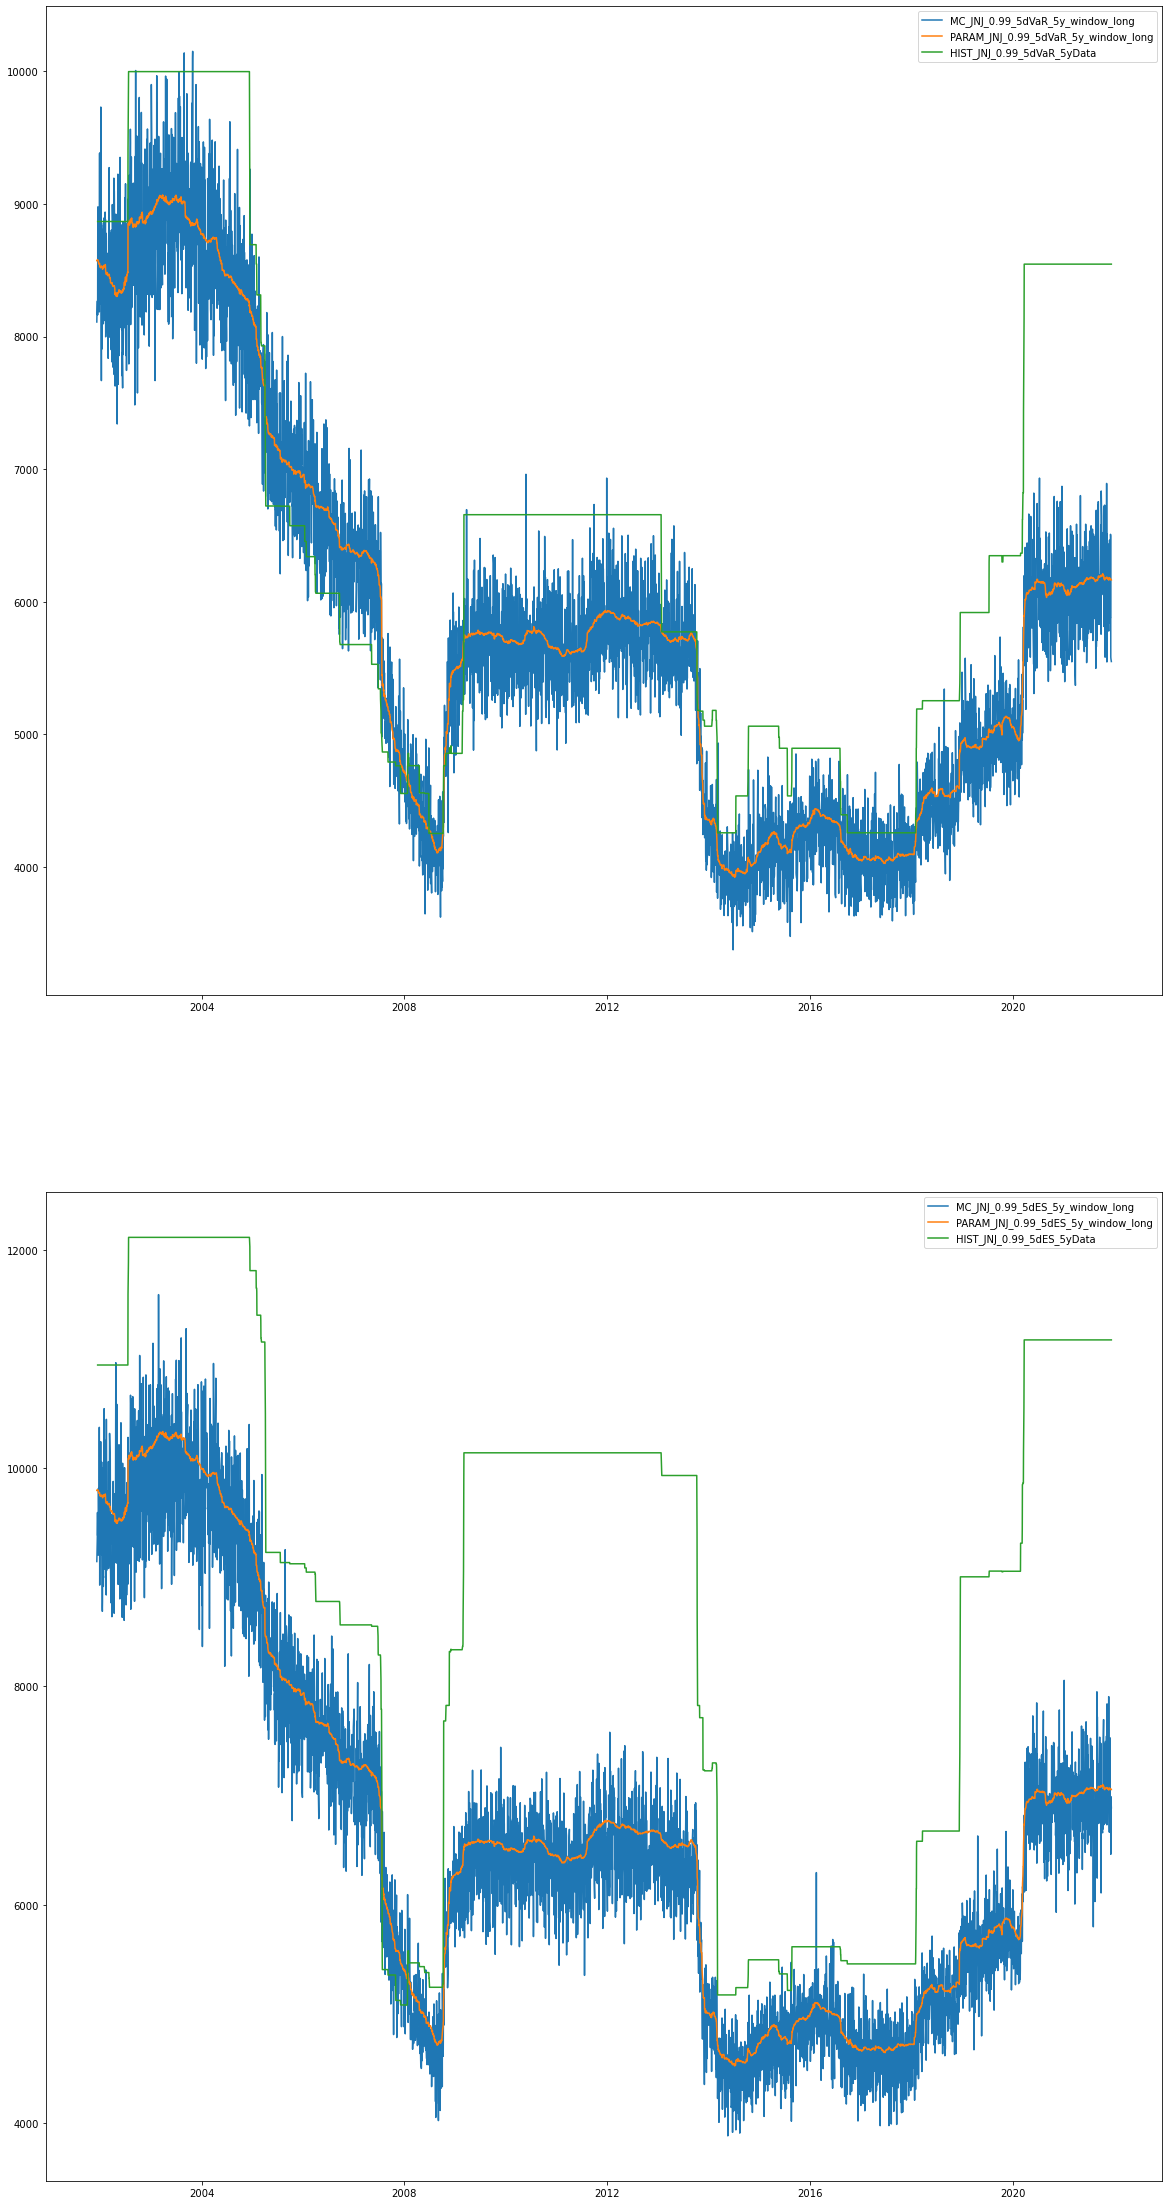

In [15]:
demo.PARAM_MC_HIST(df, 'JNJ', 0.99, 5, 5)

In [18]:
for i in range(len(tickerList[i])): 
    print("Started to calculate historical VaR and ES of:", tickerList[i])
    for j in range(len(pList)): 
        for m in range(len(tList)): 
            for n in range(len(windowList)): 
                dataFactory.HISTriskCalc(df, 100000, tickerList[i], pList[j], tList[m], windowList[n])
                                

Currently calculating 5 day 0.99 VaR and ES of JNJ , based on a historical window of length 2 years.
Currently calculating 5 day 0.99 VaR and ES of JNJ , based on a historical window of length 5 years.
Currently calculating 5 day 0.99 VaR and ES of JNJ , based on a historical window of length 10 years.
Currently calculating 10 day 0.99 VaR and ES of JNJ , based on a historical window of length 2 years.
Currently calculating 10 day 0.99 VaR and ES of JNJ , based on a historical window of length 5 years.
Currently calculating 10 day 0.99 VaR and ES of JNJ , based on a historical window of length 10 years.
Currently calculating 30 day 0.99 VaR and ES of JNJ , based on a historical window of length 2 years.
Currently calculating 30 day 0.99 VaR and ES of JNJ , based on a historical window of length 5 years.
Currently calculating 30 day 0.99 VaR and ES of JNJ , based on a historical window of length 10 years.
Currently calculating 5 day 0.975 VaR and ES of JNJ , based on a historical window